In [26]:
# 준비
import pandas as pd
import numpy as np
import warnings
import os
import scipy.stats as spst

ipynb_path = 'C:/Users/User/Documents/Wind_Power/notebooks'

In [27]:
df = pd.read_csv(os.path.join(ipynb_path, "../input/T1.csv"))

df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [28]:
# null은 없는거 확인했으니, 결측치 제거 전처리 생략

df.describe()


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


# 데이터 살펴보기

### 월별로 계절 구분

In [29]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format="%d %m %Y %H:%M")

# Extract week, month, and hour information
df['Week'] = df['Date/Time'].dt.isocalendar().week
df['Month'] = df['Date/Time'].dt.month
df['Hour'] = df['Date/Time'].dt.hour

# Define function to get season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df['Season'] = df['Month'].apply(get_season)

# Display the updated DataFrame
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter


## 풍속에 따른 power

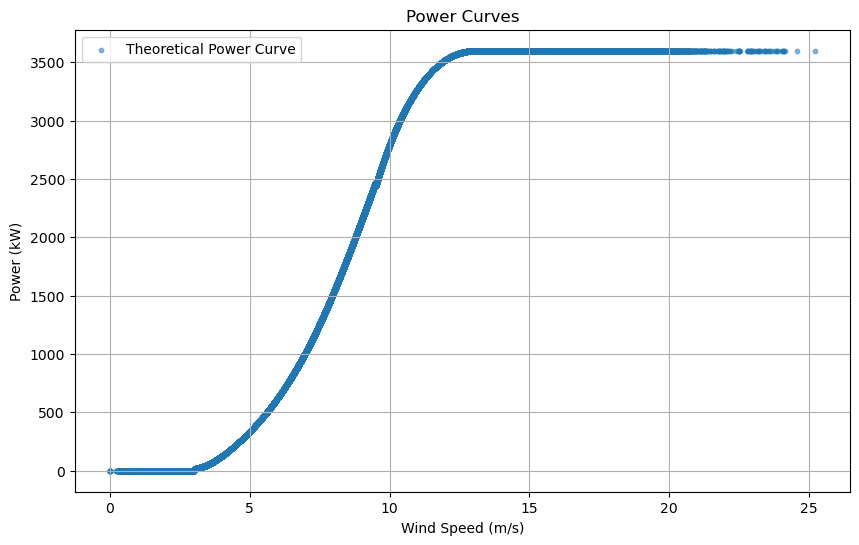

In [30]:
import matplotlib.pyplot as plt

# Plot the power curves
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind Speed (m/s)'], df['Theoretical_Power_Curve (KWh)'], s=10, alpha=0.5, label='Theoretical Power Curve')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Power Curves')
plt.legend()
plt.grid(True)
plt.show()

### 상관계수

In [31]:
corr, p_value = spst.pearsonr(df['Wind Speed (m/s)'], df['Theoretical_Power_Curve (KWh)'])

# 상관계수와 p-value 출력
print(f"Pearson correlation: {corr}")
print(f"P-value: {p_value}")

Pearson correlation: 0.9442087824669063
P-value: 0.0


귀찮으니 수치형 전부에 대해 상관계수를 살펴보면

In [32]:
# 숫자인 친구들만
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_columns = numeric_df.columns

corr_result = []

for i in range(len(numeric_columns)):
    for j in range(i + 1, len(numeric_columns)):
        col1 = numeric_columns[i]
        col2 = numeric_columns[j]
        corr, p_value = spst.pearsonr(numeric_df[col1], numeric_df[col2])
        corr_result.append({
            'col 1': col1,
            'col 2': col2,
            'correlation': corr,
            'P-value': p_value
        })

corr_df = pd.DataFrame(corr_result)

display(corr_df)

,col 1,col 2,correlation,P-value
0,LV ActivePower (kW),Wind Speed (m/s),0.912774,0.000000e+00
1,LV ActivePower (kW),Theoretical_Power_Curve (KWh),0.949918,0.000000e+00
2,LV ActivePower (kW),Wind Direction (°),-0.062702,3.381985e-45
3,Wind Speed (m/s),Theoretical_Power_Curve (KWh),0.944209,0.000000e+00
4,Wind Speed (m/s),Wind Direction (°),-0.077188,1.244539e-67
5,Theoretical_Power_Curve (KWh),Wind Direction (°),-0.099076,2.090064e-110


- `풍속(Wind Speed)`과 `이론적 발전량(Theoretical Power Curve)`은 `실제 발전량(LV ActivePower)`과 모두 높은 양의 상관관계를 가지며, 발전량 예측에 중요하다.
- `풍향(Wind Direction)`은 실제 발전량과 이론적 발전량 모두에 미치는 영향이 작다. 상관계수가 낮기 때문에, 풍력 발전량 예측에서 풍향은 중요한 변수는 아닐 것 같다.
- 이론적 발전량은 실제 발전량과 관계가 높다.

# Kaggle 코드 보고 추가해본 추가 feature
- 추가해야할 라이브러리
  - astral
    - 일출, 일몰, 황혼, 자정, 태양 고도, 달의 위상 등 천문학적 정보를 계산
  - pytz
    - 세계 시간

In [33]:
from astral import LocationInfo
from astral.sun import sun
import pytz


In [34]:


location = LocationInfo("Izmir", "Turkey", "Europe/Istanbul", 38.4192, 27.1287)
def is_day_or_night(dt):

    s = sun(location.observer, date=dt)
    sunrise = s['sunrise']
    sunset = s['sunset']
    dt = dt.tz_localize('Europe/Istanbul')
    if sunrise < dt < sunset:
            return 0 # Day
    else:
            return 1 # Night.
df['Day/Night'] = df['Date/Time'].apply(is_day_or_night)
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season,Day/Night
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter,1
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter,1
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter,1
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter,1
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter,1


In [35]:
from meteostat import Point, Hourly

location = Point(38.4192, 27.1287)  # 캐글 데이터 셋 지역인 Turkey의 도시 Izmir의 위경도

start = df['Date/Time'].min()
end = df['Date/Time'].max()

# 날짜 넣으면 해당 기간의 날씨 데이터를 가져와 줌.
# 시간별로.
data_hourly = Hourly(location, start, end)
data_hourly = data_hourly.fetch()

In [36]:
# 타임존 정보를제거
data_hourly.index = data_hourly.index.tz_localize(None)

# 시간별 데이터를 10분 간격으로 리샘플링하고, 누락된 값을 forward fill.
data_10min = data_hourly.resample('10T').ffill().reset_index()

data_10min.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2018-01-01 00:00:00,2.0,0.8,92.0,NaN,NaN,360.0,0.0,NaN,1020.6,NaN,NaN
1,2018-01-01 00:10:00,2.0,0.8,92.0,NaN,NaN,360.0,0.0,NaN,1020.6,NaN,NaN
2,2018-01-01 00:20:00,2.0,0.8,92.0,NaN,NaN,360.0,0.0,NaN,1020.6,NaN,NaN
3,2018-01-01 00:30:00,2.0,0.8,92.0,NaN,NaN,360.0,0.0,NaN,1020.6,NaN,NaN
4,2018-01-01 00:40:00,2.0,0.8,92.0,NaN,NaN,360.0,0.0,NaN,1020.6,NaN,NaN


- time: 시간 (날짜와 시간 정보)
- temp: 기온 (Temperature), 보통 섭씨로 측정
- dwpt: 이슬점 (Dew Point), 공기 중에서 수증기가 응결되어 물방울이 형성되는 온도
- rhum: 상대 습도 (Relative Humidity), 대기의 수증기량을 퍼센트로 나타낸 값
- prcp: 강수량 (Precipitation), 일정 기간 동안의 비나 눈 등의 강수량
- snow: 적설량 (Snowfall), 일정 기간 동안의 눈이 쌓인 양
- wdir: 풍향 (Wind Direction), 바람이 불어오는 방향을 각도로 나타낸 값 (보통 0~360도)
- wspd: 풍속 (Wind Speed), 바람의 속도 (일반적으로 m/s 또는 km/h)
- wpgt: 돌풍 속도 (Wind Gust), 순간적인 강한 바람의 속도
- pres: 기압 (Pressure), 대기압을 나타내는 값 (hPa 또는 mbar로 측정)
- tsun: 일조 시간 (Sunshine Duration), 태양이 비친 시간
- coco: 기상 상태 코드 (Weather Condition Code), 기상 상태를 코드로 표현 (구름, 비, 안개 등 다양한 기상 상태)
    - 0: 맑음 (Clear)
    - 1: 약간 흐림 (Partly Cloudy)
    - 2: 흐림 (Cloudy)
    - 3: 비 (Rain)
    - 4: 폭우 (Heavy Rain)
    - 5: 눈 (Snow)
    - 6: 폭설 (Heavy Snow)
    - 7: 안개 (Fog)
    - 8: 뇌우 (Thunderstorm)
    - 9: 기타 극단적인 기상 조건 (Extreme Conditions)

feature로 추가하면 좋을 친구들 : wpgt (돌풍 속도), temp (기온), pres (기압)

In [37]:
# 원본 데이터셋과 일치하도록 열 이름을 변경
weather_df = data_10min[['time', 'temp']]
weather_df = weather_df.rename(columns={'time': 'Date/Time', 'temp': 'Temperature (°C)'})

weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

df = pd.merge(df, weather_df, on='Date/Time', how='left')

df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season,Day/Night,Temperature (°C)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter,1,2.0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter,1,2.0
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter,1,2.0
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter,1,2.0
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter,1,2.0


In [38]:
df['Temperature (°C)'] = df['Temperature (°C)'].interpolate() # Nan 보간

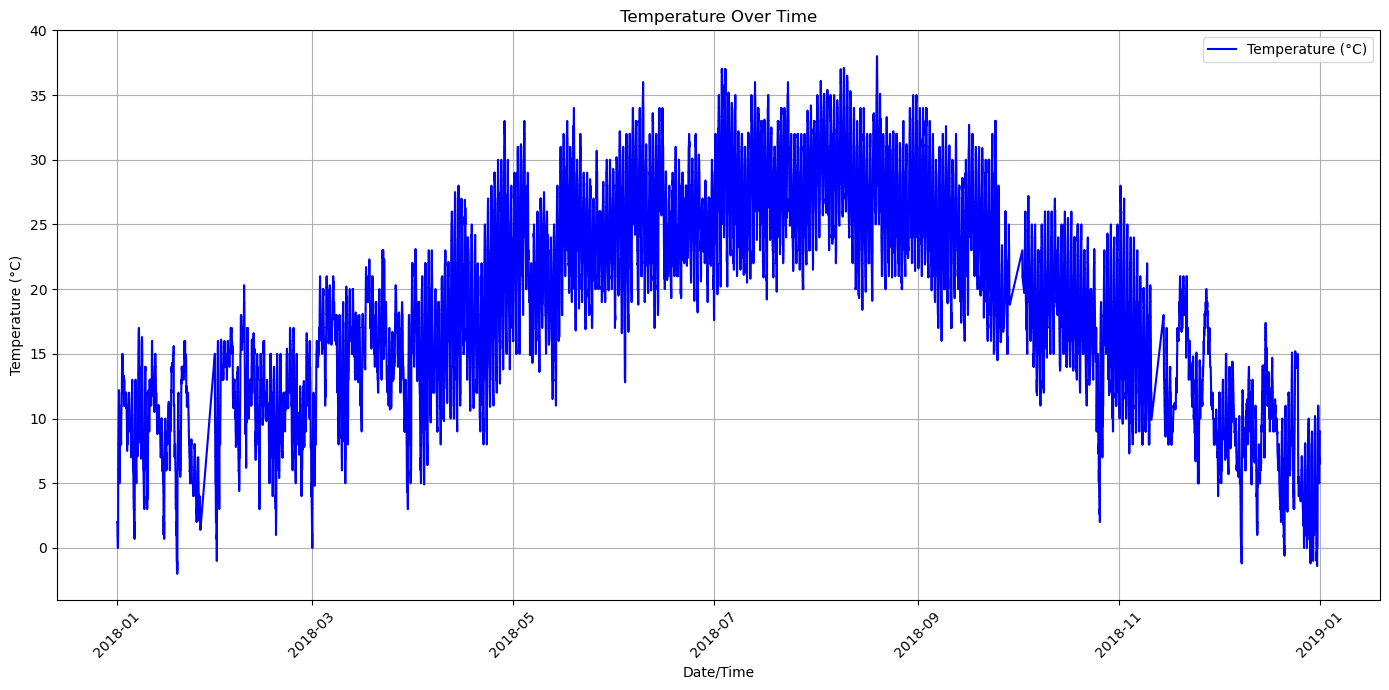

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date/Time'], df['Temperature (°C)'], label='Temperature (°C)', color='b')

plt.xlabel('Date/Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


- Yaw System : 
  - 바람의 방향에 맞춰 터빈의 방향을 조정하는 시스템.
  - 바람은 계속해서 방향을 바꾸기 때문에, 풍력 터빈이 항상 바람을 정면으로 받아야 효율적인 발전을 할 수 있음.
  - Yaw는 람의 방향을 추적하고 터빈이 항상 바람을 정면으로 받도록 방향을 조정하여 효율적인 발전을 할 수 있도록 함.

전력과 풍속 간의 관계를 그리는 산점도를 그려 풍속이 항상 높은 최적의 풍향인지 아니면 풍향에 따라 풍속이 변하는지 확인

Yaw 시스템의 존재 여부를 확인하기 위해, 바람의 방향과 발전량 간의 관계를 분석.

**발전량 - 풍향** : Yaw 시스템이 있을 경우, 발전량이 풍향에 관계없이 일정하게 유지될 것이다.

**발전량 - 풍속** : 바람의 속도와 방향이 발전량에 미치는 영향을 확인하여, 최적의 풍향을 찾아내고 Yaw 시스템의 효율을 분석해볼 수 있다.

- 이미 해놓은 사람의 판단을 정리하면,

  - Yaw 시스템이 존재할 가능성은 있지만, 바람의 방향이 크게 변하지 않기 때문에 Yaw 시스템이 자주 작동하지 않아 이를 판단하기 어려운 상황이라고 한다.

## **Effective Theoretical Power**을 계산하기 위한 알고리즘
터빈이 최적의 풍향에서 얼마나 가까운지에 따라 계산.

터빈이 최적의 풍향에 가까울수록 실제로 얻을 수 있는 발전량이 더 높다는 가정에 기반한다.

(Yaw 미고려)

In [40]:
def get_deviation(wind_direction):
    optimal_angles = [60, 210]
    deviations = [min(abs(wind_direction - angle), abs(wind_direction - angle + 360), abs(wind_direction - angle - 360)) for angle in optimal_angles]
    return min(deviations)

df['Effective Theoretical Power(kWh)'] = (100 - ((df['Wind Direction (°)'].apply(get_deviation) / 360) * 100)) * df['Theoretical_Power_Curve (KWh)']
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season,Day/Night,Temperature (°C),Effective Theoretical Power(kWh)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter,1,2.0,35851.134228
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter,1,2.0,43522.711755
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter,1,2.0,32296.507987
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter,1,2.0,42830.260341
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter,1,2.0,41566.071686


# Feature Engineering 아이디어

1. `기압(pres)`을 feature로 추가하면 대기안정도를 고려할 수 있지 않을까.
2. 이동평균, 이동회귀 항을 고려.
3. 곱하면 뭐가 나올지 실험 (상호작용 항) (풍속vs풍향, 온돞vs풍속)
4. cos, sin 함수로 주기성 만들어주기 (권용민님 아이디어)
5. ~~ 이론적 발전량과의 차이~~
   - ~~실제 조건에서 터빈의 효율성을 반영하는 데 도움이 될 수도 있지 않을까 ~~
6. 기압 추가하는 김에 기입과 풍속의 곱셈항도 추가해보기

In [41]:
# 기압 추가

weather_df = data_10min[['time', 'pres']]
weather_df = weather_df.rename(columns={'time': 'Date/Time', 'pres': 'Pressure (hPa)'})

# Date/Time 열을 datetime 형식으로 변환
weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

# 기존 df와 병합 (Date/Time 열을 기준으로)
df = pd.merge(df, weather_df, on='Date/Time', how='left')

df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season,Day/Night,Temperature (°C),Effective Theoretical Power(kWh),Pressure (hPa)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter,1,2.0,35851.134228,1020.6
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter,1,2.0,43522.711755,1020.6
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter,1,2.0,32296.507987,1020.6
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter,1,2.0,42830.260341,1020.6
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter,1,2.0,41566.071686,1020.6


In [42]:
# 풍속*풍향
df['Wind_Speed_Direction_Interaction'] = df['Wind Speed (m/s)'] * df['Wind Direction (°)']
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season,Day/Night,Temperature (°C),Effective Theoretical Power(kWh),Pressure (hPa),Wind_Speed_Direction_Interaction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter,1,2.0,35851.134228,1020.6,1380.920302
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter,1,2.0,43522.711755,1020.6,1523.777210
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter,1,2.0,32296.507987,1020.6,1421.707968
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter,1,2.0,42830.260341,1020.6,1535.232389
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter,1,2.0,41566.071686,1020.6,1481.915476


In [43]:
# cos, sin 함수로 주기성을 갖도록 해서 feature로 넣어보기

df['Wind_Dir_Sin'] = np.sin(np.radians(df['Wind Direction (°)']))
df['Wind_Dir_Cos'] = np.cos(np.radians(df['Wind Direction (°)']))



In [44]:
df['Pressure_Wind_Interaction'] = df['Pressure (hPa)'] * df['Wind Speed (m/s)']


In [45]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season,Day/Night,Temperature (°C),Effective Theoretical Power(kWh),Pressure (hPa),Wind_Speed_Direction_Interaction,Wind_Dir_Sin,Wind_Dir_Cos,Pressure_Wind_Interaction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter,1,2.0,35851.134228,1020.6,1380.920302,-0.984792,-0.173736,5420.749563
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter,1,2.0,43522.711755,1020.6,1523.777210,-0.999719,-0.023715,5789.013461
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter,1,2.0,32296.507987,1020.6,1421.707968,-0.998998,0.044749,5323.487155
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter,1,2.0,42830.260341,1020.6,1535.232389,-0.999759,0.021956,5776.263455
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter,1,2.0,41566.071686,1020.6,1481.915476,-0.997151,-0.075426,5692.846524


## XGBoost에서 Feature Importance를 산출하는 방법:

XGBoost는 주로 Gain, Cover, 그리고 Frequency 세 가지 기준으로 feature importance를 계산한다.

- Gain:

    - 각 특성이 모델의 정확도를 얼마나 향상시켰는지를 기반으로 한다.
    - 더 많은 정보를 제공하는 특성일수록 Gain 값이 크다.
- Cover:
    - 해당 특성이 분할에 사용된 데이터의 양을 기반으로 계산.
    - 많은 데이터를 포함하는 분할에 사용된 특성일수록 중요도가 높게 나타난다.
- Frequency:
    - 해당 특성이 분할에 사용된 빈도를 기반으로 한다.
    - 많이 사용된 특성일수록 중요도가 높다.
    - 기본적으로 xgb.plot_importance()는 Gain을 사용하여 중요도를 시각화하지만, 필요에 따라 다른 기준으로 변경할 수도 있음.

In [46]:
# 특징 중요도 산출

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.get_dummies(df, ['Season'])
df = df.drop(columns= 'Date/Time')
scaler = StandardScaler()
columns = df.columns

# Fit and transform the data
df = scaler.fit_transform(df)

# Convert the result back to a DataFrame
df = pd.DataFrame(df, columns = columns)

df = pd.get_dummies(df)
y = df['LV ActivePower (kW)']
X = df.drop(columns=['LV ActivePower (kW)'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



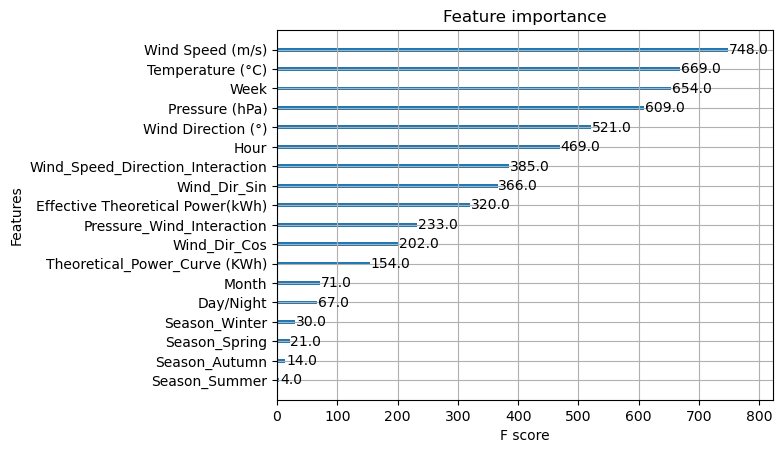

In [47]:


import matplotlib.pyplot as plt
import xgboost as xgb

# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = X.columns


# Plot feature importances
xgb.plot_importance(model)
plt.show()

기압, 풍속-풍향곱셈항이 높은 importance를 보임을 확인